In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
from datetime import datetime
from collections import OrderedDict
from toolz.curried import pipe, curry, compose
warnings.filterwarnings('ignore')

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [4]:
import chnet.ch_tools as ch_tools
import chnet.utilities as ch_utils
import chnet.ch_generator as ch_gen
from chnet.torchsummary import summary
from chnet.ch_loader import CahnHillDataset

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

## Loss Functions

In [6]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

def get_primes(n):
    # https://stackoverflow.com/questions/2068372/fastest-way-to-list-all-primes-below-n-in-python/3035188#3035188
    """ Input n>=6, Returns a array of primes, 2 <= p < n """
    sieve = np.ones(n//3 + (n%6==2), dtype=np.bool)
    sieve[0] = False
    for i in range(int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[      ((k*k)//3)      ::2*k] = False
            sieve[(k*k+4*k-2*k*(i&1))//3::2*k] = False
    return np.r_[2,3,((3*np.nonzero(sieve)[0]+1)|1)]

# Set Device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [10]:
from chnet.models import UNet_loop as UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32, 
             temporal=3).to(device)

summary(model, input_size=(10,1, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Padder-1            [-1, 1, 98, 98]               0
            Conv2d-2           [-1, 32, 96, 96]             288
       BatchNorm2d-3           [-1, 32, 96, 96]              64
              ReLU-4           [-1, 32, 96, 96]               0
            Padder-5           [-1, 32, 98, 98]               0
            Conv2d-6           [-1, 32, 96, 96]           9,216
       BatchNorm2d-7           [-1, 32, 96, 96]              64
              ReLU-8           [-1, 32, 96, 96]               0
         AvgPool2d-9           [-1, 32, 48, 48]               0
           Padder-10           [-1, 32, 50, 50]               0
           Conv2d-11           [-1, 64, 48, 48]          18,432
      BatchNorm2d-12           [-1, 64, 48, 48]             128
             ReLU-13           [-1, 64, 48, 48]               0
           Padder-14           [-1, 64,

(tensor(23288163), tensor(23288163))

# Data Generator

In [11]:
x_data, y_data = ch_gen.data_generator(nsamples=4, 
                                       dim_x=64, 
                                       init_steps=1, 
                                       delta_sim_steps=100,
                                       dx=0.25, 
                                       dt=0.01,
                                       gamma=1.0,
                                       n_step=10,
                                       seed = None,
                                       device=device)

print(x_data.shape)
print(y_data.shape)

(4, 10, 64, 64)
(4, 10, 64, 64)


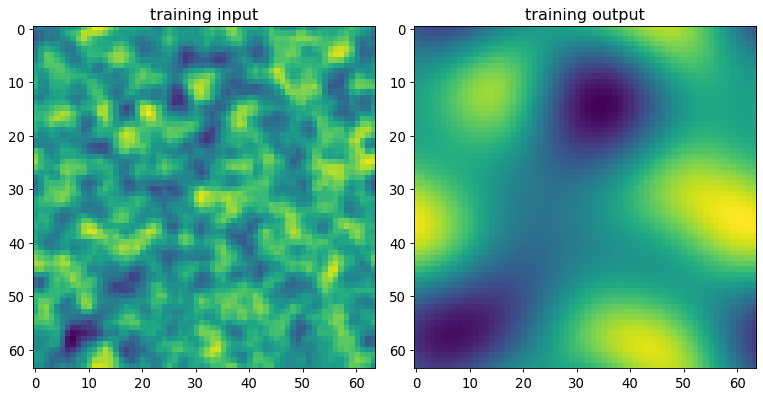

In [13]:
im_x = x_data[0, 0]
im_y = y_data[0, -1]
ch_utils.draw_by_side([im_x, im_y], sub_titles=["training input", "training output"])

In [14]:
transformer_x = lambda x: x[:,None]
transformer_y = lambda x: x[:,None]

dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print("\n", x.shape, "\n", y.shape)


 torch.Size([1, 10, 1, 64, 64]) 
 torch.Size([1, 10, 1, 64, 64])


In [16]:
from chnet.models import UNet_loop as UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32, 
             temporal=10).double().to(device)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.1076, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [8]:
## Process Parameters
dim_x=96

init_steps=1
delta_sim_steps=500

n_step = 10
dx = 0.25 
dt = 0.01
gamma=1.0
m_l=-0.05, 
m_r=+0.05,


seed_trn = 110364
n_samples_trn = 1024
ngf = 32

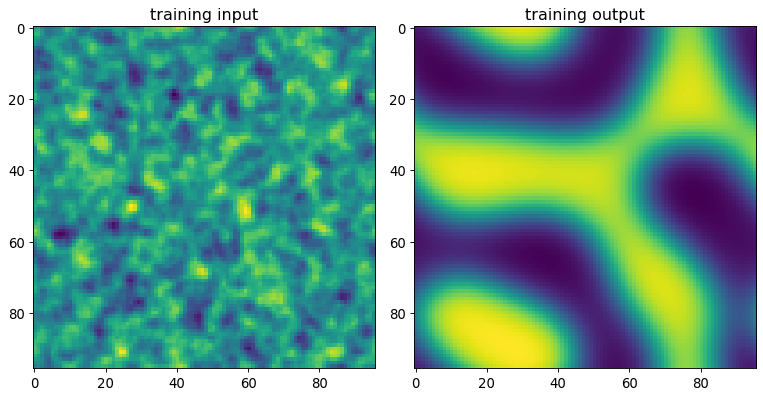

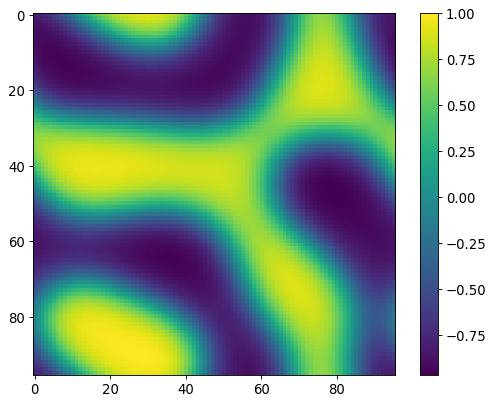

CPU times: user 13.2 s, sys: 9.7 s, total: 22.9 s
Wall time: 21 s


In [20]:
%%time
x_trn, y_trn = ch_gen.data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx=dx, 
                              dt=dt,
                              m_l=m_l, 
                              m_r=m_r,
                              n_step=n_step,
                              gamma=gamma, 
                              seed=2513,
                              device=device)

ch_utils.draw_by_side([x_trn[0][0], y_trn[0][-1]], sub_titles=["training input", "training output"])
ch_utils.draw_im(y_trn[0][-1])

In [25]:
from chnet.models import UNet_loop as UNet
model = UNet(in_channels=1, out_channels=1, init_features=ngf, temporal=n_step).double().to(device)


trn_losses = []
val_losses = []

In [58]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def mse_loss_steps(y1, y2, steps, scale=1.):
    """standard MSE definition"""
    
    loss = 0.0
    for t in range(steps):
        loss += ((y1[:,t] - y2[:,t]) ** 2).sum() / y1[:,t].data.nelement() * scale
    return loss

In [60]:
criterion = mse_loss_steps(steps=n_step, scale=10000)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 5
primes = get_primes(1000)[20:100]

print("No. of datasets: {}".format(len(primes)))

for num, prime in enumerate(primes):
    # Loss and optimizer
    x_trn, y_trn = ch_gen.data_generator(nsamples=n_samples_trn, 
                                  dim_x=dim_x, 
                                  init_steps=init_steps, 
                                  delta_sim_steps = delta_sim_steps,
                                  dx=dx, 
                                  dt=dt,
                                  m_l=m_l, 
                                  m_r=m_r,
                                  n_step=n_step,
                                  gamma=gamma, 
                                  seed=2513*prime,
                                  device = device)


    trn_dataset = CahnHillDataset(x_trn, y_trn, 
                                  transform_x=lambda x: x[:,None], 
                                  transform_y=lambda x: x[:,None])
    
    trn_loader = DataLoader(trn_dataset, 
                            batch_size=8, 
                            shuffle=True, 
                            num_workers=4)
    
    print("Training Run: {}, prime: {}".format(num, prime))
    
    total_step = len(trn_loader)
    
    for epoch in range(num_epochs):  
        torch.save(model.state_dict(), "out/unet_pytorch_ch{}_{}_{}_loop.pt".format(ngf, init_steps, delta_sim_steps))
        for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):

            model.train()

            x = item_trn['x'].to(device)
            y_tru = item_trn['y'].to(device)

            # Forward pass
#             y_prd = model(x)
#             loss = criterion(y_tru, y_prd)
            
            loss = 0.0
            for t in range(n_step):
                y_prd = model.unets[t](x[:,t])
                loss = loss + mse_loss(y_tru[:,t], y_prd, scale=10000)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trn_losses.append(np.sqrt(loss.item()))

            if (i) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}'.format(epoch+1, 
                                                                                     num_epochs, 
                                                                                     i+1, 
                                                                                     total_step, 
                                                                                     np.mean(trn_losses[-16:])))

No. of datasets: 80
Training Run: 0, prime: 73


Epoch [1/5], Step [1/128], Training Loss: 0.35352067070
Epoch [1/5], Step [101/128], Training Loss: 4.08582086868



Epoch [2/5], Step [1/128], Training Loss: 3.97506283232
Epoch [2/5], Step [101/128], Training Loss: 4.06577523497



Epoch [3/5], Step [1/128], Training Loss: 3.70424791678
Epoch [3/5], Step [101/128], Training Loss: 3.95986814222



Epoch [4/5], Step [1/128], Training Loss: 4.07733336456
Epoch [4/5], Step [101/128], Training Loss: 4.31644268269



Epoch [5/5], Step [1/128], Training Loss: 4.18153661556
Epoch [5/5], Step [101/128], Training Loss: 4.27810394045

Training Run: 1, prime: 79


Epoch [1/5], Step [1/128], Training Loss: 3.99192951397
Epoch [1/5], Step [101/128], Training Loss: 3.91469990770



Epoch [2/5], Step [1/128], Training Loss: 4.62200824312
Epoch [2/5], Step [101/128], Training Loss: 3.53637688651



Epoch [3/5], Step [1/128], Training Loss: 4.23027908982
Epoch [3/5], Step [101/128], Training Loss: 4.27520522020



Epoch [4/5], Step [1/128], Training Loss: 3.80160083646
Epoch [4/5], Step [101/128], Training Loss: 4.45052850998



Epoch [5/5], Step [1/128], Training Loss: 3.96059799010
Epoch [5/5], Step [101/128], Training Loss: 3.71968969193

Training Run: 2, prime: 83


Epoch [1/5], Step [1/128], Training Loss: 3.77465152955
Epoch [1/5], Step [101/128], Training Loss: 4.35548249936



Epoch [2/5], Step [1/128], Training Loss: 4.04861030670
Epoch [2/5], Step [101/128], Training Loss: 3.94040510555



Epoch [3/5], Step [1/128], Training Loss: 4.02222369192
Epoch [3/5], Step [101/128], Training Loss: 4.47195536176



Epoch [4/5], Step [1/128], Training Loss: 4.15120380913
Epoch [4/5], Step [101/128], Training Loss: 3.84744864659



Epoch [5/5], Step [1/128], Training Loss: 3.70019556011
Epoch [5/5], Step [101/128], Training Loss: 4.48246477015

Training Run: 3, prime: 89


Epoch [1/5], Step [1/128], Training Loss: 3.84211068117
Epoch [1/5], Step [101/128], Training Loss: 4.14197579998



Epoch [2/5], Step [1/128], Training Loss: 3.74469913677
Epoch [2/5], Step [101/128], Training Loss: 3.82681046541



Epoch [3/5], Step [1/128], Training Loss: 3.80474955134
Epoch [3/5], Step [101/128], Training Loss: 3.84512320882



Epoch [4/5], Step [1/128], Training Loss: 3.44889281317
Epoch [4/5], Step [101/128], Training Loss: 3.62182929530



Epoch [5/5], Step [1/128], Training Loss: 3.56134103173
Epoch [5/5], Step [101/128], Training Loss: 3.76523678636

Training Run: 4, prime: 97


Epoch [1/5], Step [1/128], Training Loss: 3.84201130270
Epoch [1/5], Step [101/128], Training Loss: 3.89357110780



Epoch [2/5], Step [1/128], Training Loss: 3.94806631301
Epoch [2/5], Step [101/128], Training Loss: 3.96766858260



Epoch [3/5], Step [1/128], Training Loss: 3.90084654497
Epoch [3/5], Step [101/128], Training Loss: 3.73108585756



Epoch [4/5], Step [1/128], Training Loss: 3.70389851114
Epoch [4/5], Step [101/128], Training Loss: 3.57082039408



Epoch [5/5], Step [1/128], Training Loss: 3.44154924001
Epoch [5/5], Step [101/128], Training Loss: 3.51340284712

Training Run: 5, prime: 101


Epoch [1/5], Step [1/128], Training Loss: 3.42457355456
Epoch [1/5], Step [101/128], Training Loss: 3.54507377052



Epoch [2/5], Step [1/128], Training Loss: 3.86675978411
Epoch [2/5], Step [101/128], Training Loss: 3.44294206882



Epoch [3/5], Step [1/128], Training Loss: 3.67908201863
Epoch [3/5], Step [101/128], Training Loss: 4.08892287422



Epoch [4/5], Step [1/128], Training Loss: 3.73267977727
Epoch [4/5], Step [101/128], Training Loss: 3.65823002875



Epoch [5/5], Step [1/128], Training Loss: 3.51970564348
Epoch [5/5], Step [101/128], Training Loss: 3.39898619654

Training Run: 6, prime: 103


Epoch [1/5], Step [1/128], Training Loss: 3.89050711760
Epoch [1/5], Step [101/128], Training Loss: 3.49480355816



Epoch [2/5], Step [1/128], Training Loss: 3.61424062709
Epoch [2/5], Step [101/128], Training Loss: 3.70130702791



Epoch [3/5], Step [1/128], Training Loss: 3.77526611953
Epoch [3/5], Step [101/128], Training Loss: 3.55866440103



Epoch [4/5], Step [1/128], Training Loss: 3.23937581382
Epoch [4/5], Step [101/128], Training Loss: 3.77738043536



Epoch [5/5], Step [1/128], Training Loss: 3.20306249490
Epoch [5/5], Step [101/128], Training Loss: 3.10626931447

Training Run: 7, prime: 107


Epoch [1/5], Step [1/128], Training Loss: 3.50713711258
Epoch [1/5], Step [101/128], Training Loss: 3.86707080263



Epoch [2/5], Step [1/128], Training Loss: 3.30070952950
Epoch [2/5], Step [101/128], Training Loss: 3.63952843952



Epoch [3/5], Step [1/128], Training Loss: 3.58826526678
Epoch [3/5], Step [101/128], Training Loss: 3.59637899138



Epoch [4/5], Step [1/128], Training Loss: 3.25150264572
Epoch [4/5], Step [101/128], Training Loss: 3.68443318644



Epoch [5/5], Step [1/128], Training Loss: 3.03398156959
Epoch [5/5], Step [101/128], Training Loss: 3.32272230332

Training Run: 8, prime: 109


Epoch [1/5], Step [1/128], Training Loss: 3.37493033236
Epoch [1/5], Step [101/128], Training Loss: 3.39041977253



Epoch [2/5], Step [1/128], Training Loss: 3.35048859435
Epoch [2/5], Step [101/128], Training Loss: 3.20964664073



Epoch [3/5], Step [1/128], Training Loss: 3.57776375796
Epoch [3/5], Step [101/128], Training Loss: 3.63203480052



Epoch [4/5], Step [1/128], Training Loss: 3.49295168799
Epoch [4/5], Step [101/128], Training Loss: 3.08581421115



Epoch [5/5], Step [1/128], Training Loss: 3.56787955105
Epoch [5/5], Step [101/128], Training Loss: 3.71498083161

Training Run: 9, prime: 113


Epoch [1/5], Step [1/128], Training Loss: 3.08258369531
Epoch [1/5], Step [101/128], Training Loss: 3.65834070242



Epoch [2/5], Step [1/128], Training Loss: 3.75462778079
Epoch [2/5], Step [101/128], Training Loss: 3.55845670029



Epoch [3/5], Step [1/128], Training Loss: 3.20412924151
Epoch [3/5], Step [101/128], Training Loss: 3.38456397383



Epoch [4/5], Step [1/128], Training Loss: 3.13334004154
Epoch [4/5], Step [101/128], Training Loss: 3.18065394114



Epoch [5/5], Step [1/128], Training Loss: 3.12528330694
Epoch [5/5], Step [101/128], Training Loss: 3.51855192220

Training Run: 10, prime: 127


Epoch [1/5], Step [1/128], Training Loss: 3.47458090929
Epoch [1/5], Step [101/128], Training Loss: 2.95289544361



Epoch [2/5], Step [1/128], Training Loss: 3.40537661772
Epoch [2/5], Step [101/128], Training Loss: 3.22745405593



Epoch [3/5], Step [1/128], Training Loss: 2.96941896819
Epoch [3/5], Step [101/128], Training Loss: 3.33003326436



Epoch [4/5], Step [1/128], Training Loss: 3.30713164802
Epoch [4/5], Step [101/128], Training Loss: 3.27352790118



Epoch [5/5], Step [1/128], Training Loss: 3.20788276318
Epoch [5/5], Step [101/128], Training Loss: 3.71294850692

Training Run: 11, prime: 131


Epoch [1/5], Step [1/128], Training Loss: 3.62098430711
Epoch [1/5], Step [101/128], Training Loss: 3.34801326965



Epoch [2/5], Step [1/128], Training Loss: 3.09029726227
Epoch [2/5], Step [101/128], Training Loss: 3.09770891715



Epoch [3/5], Step [1/128], Training Loss: 3.64047474461
Epoch [3/5], Step [101/128], Training Loss: 3.33312816166



Epoch [4/5], Step [1/128], Training Loss: 3.15862483893
Epoch [4/5], Step [101/128], Training Loss: 3.05226866376



Epoch [5/5], Step [1/128], Training Loss: 2.99237184809
Epoch [5/5], Step [101/128], Training Loss: 3.26925296163

Training Run: 12, prime: 137


Epoch [1/5], Step [1/128], Training Loss: 3.19067992293
Epoch [1/5], Step [101/128], Training Loss: 2.98580190637



Epoch [2/5], Step [1/128], Training Loss: 3.19698509101
Epoch [2/5], Step [101/128], Training Loss: 3.25718974349



Epoch [3/5], Step [1/128], Training Loss: 3.10701793304
Epoch [3/5], Step [101/128], Training Loss: 3.11632762717



Epoch [4/5], Step [1/128], Training Loss: 2.95046691674
Epoch [4/5], Step [101/128], Training Loss: 3.00046394335



Epoch [5/5], Step [1/128], Training Loss: 3.26886413416
Epoch [5/5], Step [101/128], Training Loss: 2.96848021624

Training Run: 13, prime: 139


Epoch [1/5], Step [1/128], Training Loss: 3.29846642577
Epoch [1/5], Step [101/128], Training Loss: 3.90124640766



Epoch [2/5], Step [1/128], Training Loss: 3.18282970425
Epoch [2/5], Step [101/128], Training Loss: 3.22969849244



Epoch [3/5], Step [1/128], Training Loss: 2.78551160914
Epoch [3/5], Step [101/128], Training Loss: 3.13214689574



Epoch [4/5], Step [1/128], Training Loss: 3.17130179296
Epoch [4/5], Step [101/128], Training Loss: 3.28707658327



Epoch [5/5], Step [1/128], Training Loss: 3.11269537109
Epoch [5/5], Step [101/128], Training Loss: 3.05101874132

Training Run: 14, prime: 149


Epoch [1/5], Step [1/128], Training Loss: 2.99251946214
Epoch [1/5], Step [101/128], Training Loss: 2.91629594137



Epoch [2/5], Step [1/128], Training Loss: 2.99367163437
Epoch [2/5], Step [101/128], Training Loss: 2.86324708673



Epoch [3/5], Step [1/128], Training Loss: 3.16759742349
Epoch [3/5], Step [101/128], Training Loss: 2.79533177061



Epoch [4/5], Step [1/128], Training Loss: 3.14138524965
Epoch [4/5], Step [101/128], Training Loss: 3.11508209136



Epoch [5/5], Step [1/128], Training Loss: 3.20742222752
Epoch [5/5], Step [101/128], Training Loss: 3.06515430645

Training Run: 15, prime: 151


Epoch [1/5], Step [1/128], Training Loss: 2.86305584571
Epoch [1/5], Step [101/128], Training Loss: 2.95489733179



Epoch [2/5], Step [1/128], Training Loss: 3.03517615683
Epoch [2/5], Step [101/128], Training Loss: 2.85522335933



Epoch [3/5], Step [1/128], Training Loss: 2.96317874688
Epoch [3/5], Step [101/128], Training Loss: 3.29311257129



Epoch [4/5], Step [1/128], Training Loss: 3.12706422478
Epoch [4/5], Step [101/128], Training Loss: 2.65753549435



Epoch [5/5], Step [1/128], Training Loss: 2.93655845610
Epoch [5/5], Step [101/128], Training Loss: 3.14674540974

Training Run: 16, prime: 157


Epoch [1/5], Step [1/128], Training Loss: 2.75827054697
Epoch [1/5], Step [101/128], Training Loss: 3.21653345831



Epoch [2/5], Step [1/128], Training Loss: 2.68468582155
Epoch [2/5], Step [101/128], Training Loss: 3.10485350645



Epoch [3/5], Step [1/128], Training Loss: 2.82190811565
Epoch [3/5], Step [101/128], Training Loss: 2.69754477331



Epoch [4/5], Step [1/128], Training Loss: 3.03169044582
Epoch [4/5], Step [101/128], Training Loss: 2.95100401734



Epoch [5/5], Step [1/128], Training Loss: 2.85034708057
Epoch [5/5], Step [101/128], Training Loss: 2.93409665707

Training Run: 17, prime: 163


Epoch [1/5], Step [1/128], Training Loss: 2.80465190951
Epoch [1/5], Step [101/128], Training Loss: 2.53452593444



Epoch [2/5], Step [1/128], Training Loss: 2.80712057430
Epoch [2/5], Step [101/128], Training Loss: 2.92059137173



Epoch [3/5], Step [1/128], Training Loss: 2.72028039014
Epoch [3/5], Step [101/128], Training Loss: 3.12334414590



Epoch [4/5], Step [1/128], Training Loss: 2.95334690503
Epoch [4/5], Step [101/128], Training Loss: 2.87358898585



Epoch [5/5], Step [1/128], Training Loss: 2.98073361617
Epoch [5/5], Step [101/128], Training Loss: 2.67276926050

Training Run: 18, prime: 167


Epoch [1/5], Step [1/128], Training Loss: 2.70497654916
Epoch [1/5], Step [101/128], Training Loss: 2.84402960922



Epoch [2/5], Step [1/128], Training Loss: 2.75749436275
Epoch [2/5], Step [101/128], Training Loss: 2.83946004357



Epoch [3/5], Step [1/128], Training Loss: 2.86099343496
Epoch [3/5], Step [101/128], Training Loss: 2.68369091085



Epoch [4/5], Step [1/128], Training Loss: 2.83231366062
Epoch [4/5], Step [101/128], Training Loss: 2.94485989241



Epoch [5/5], Step [1/128], Training Loss: 2.92154888972
Epoch [5/5], Step [101/128], Training Loss: 2.75044238046

Training Run: 19, prime: 173


Epoch [1/5], Step [1/128], Training Loss: 2.94826688053
Epoch [1/5], Step [101/128], Training Loss: 2.73848468206



Epoch [2/5], Step [1/128], Training Loss: 2.87679047105
Epoch [2/5], Step [101/128], Training Loss: 2.79629422882



Epoch [3/5], Step [1/128], Training Loss: 3.12199260563
Epoch [3/5], Step [101/128], Training Loss: 3.01047403275



Epoch [4/5], Step [1/128], Training Loss: 2.82369036913
Epoch [4/5], Step [101/128], Training Loss: 3.24793714734



Epoch [5/5], Step [1/128], Training Loss: 2.72029147125
Epoch [5/5], Step [101/128], Training Loss: 2.62528387923

Training Run: 20, prime: 179


Epoch [1/5], Step [1/128], Training Loss: 2.50126461963
Epoch [1/5], Step [101/128], Training Loss: 2.92024009619



Epoch [2/5], Step [1/128], Training Loss: 2.84502256651
Epoch [2/5], Step [101/128], Training Loss: 2.88024223870



Epoch [3/5], Step [1/128], Training Loss: 3.17130064104
Epoch [3/5], Step [101/128], Training Loss: 2.77601021250



Epoch [4/5], Step [1/128], Training Loss: 3.42419086629
Epoch [4/5], Step [101/128], Training Loss: 2.71775056779



Epoch [5/5], Step [1/128], Training Loss: 3.24473125983
Epoch [5/5], Step [101/128], Training Loss: 2.72109711628

Training Run: 21, prime: 181


Epoch [1/5], Step [1/128], Training Loss: 2.63311464231
Epoch [1/5], Step [101/128], Training Loss: 2.74077861109



Epoch [2/5], Step [1/128], Training Loss: 2.70194968493
Epoch [2/5], Step [101/128], Training Loss: 2.63214189126



Epoch [3/5], Step [1/128], Training Loss: 2.64086347489
Epoch [3/5], Step [101/128], Training Loss: 2.90070626750



Epoch [4/5], Step [1/128], Training Loss: 2.88365687241
Epoch [4/5], Step [101/128], Training Loss: 2.73379309153



Epoch [5/5], Step [1/128], Training Loss: 2.65823241185
Epoch [5/5], Step [101/128], Training Loss: 2.91976482234

Training Run: 22, prime: 191


Epoch [1/5], Step [1/128], Training Loss: 2.78084188576
Epoch [1/5], Step [101/128], Training Loss: 2.73755289465



Epoch [2/5], Step [1/128], Training Loss: 2.61020669136
Epoch [2/5], Step [101/128], Training Loss: 3.05897235161



Epoch [3/5], Step [1/128], Training Loss: 2.71222318278
Epoch [3/5], Step [101/128], Training Loss: 2.89625127232



Epoch [4/5], Step [1/128], Training Loss: 2.69464488649
Epoch [4/5], Step [101/128], Training Loss: 2.66452433322



Epoch [5/5], Step [1/128], Training Loss: 2.68775286663
Epoch [5/5], Step [101/128], Training Loss: 3.15533085624

Training Run: 23, prime: 193


Epoch [1/5], Step [1/128], Training Loss: 2.59601460683
Epoch [1/5], Step [101/128], Training Loss: 2.89481800259



Epoch [2/5], Step [1/128], Training Loss: 2.71012368151
Epoch [2/5], Step [101/128], Training Loss: 3.09866203878



Epoch [3/5], Step [1/128], Training Loss: 2.86628701630
Epoch [3/5], Step [101/128], Training Loss: 2.63435174147



Epoch [4/5], Step [1/128], Training Loss: 2.54771955730
Epoch [4/5], Step [101/128], Training Loss: 2.70075540287



Epoch [5/5], Step [1/128], Training Loss: 2.38261180708
Epoch [5/5], Step [101/128], Training Loss: 2.73698715366

Training Run: 24, prime: 197


Epoch [1/5], Step [1/128], Training Loss: 2.84474145938
Epoch [1/5], Step [101/128], Training Loss: 2.65526544612



Epoch [2/5], Step [1/128], Training Loss: 2.75973920928
Epoch [2/5], Step [101/128], Training Loss: 2.88287598202



Epoch [3/5], Step [1/128], Training Loss: 3.04309069165
Epoch [3/5], Step [101/128], Training Loss: 2.64498669710



Epoch [4/5], Step [1/128], Training Loss: 3.13599640027
Epoch [4/5], Step [101/128], Training Loss: 2.48758736945



Epoch [5/5], Step [1/128], Training Loss: 2.45052914008
Epoch [5/5], Step [101/128], Training Loss: 2.47034218521

Training Run: 25, prime: 199


Epoch [1/5], Step [1/128], Training Loss: 2.64591793079
Epoch [1/5], Step [101/128], Training Loss: 2.67099551894



Epoch [2/5], Step [1/128], Training Loss: 2.60282278242
Epoch [2/5], Step [101/128], Training Loss: 2.51790968205



Epoch [3/5], Step [1/128], Training Loss: 2.46554791178
Epoch [3/5], Step [101/128], Training Loss: 2.51073376185



Epoch [4/5], Step [1/128], Training Loss: 2.88815050357
Epoch [4/5], Step [101/128], Training Loss: 2.51632543401



Epoch [5/5], Step [1/128], Training Loss: 2.49028253010
Epoch [5/5], Step [101/128], Training Loss: 2.48302345408

Training Run: 26, prime: 211


Epoch [1/5], Step [1/128], Training Loss: 2.58114351420
Epoch [1/5], Step [101/128], Training Loss: 2.58125979302



Epoch [2/5], Step [1/128], Training Loss: 2.71651121259
Epoch [2/5], Step [101/128], Training Loss: 2.70810521491



Epoch [3/5], Step [1/128], Training Loss: 2.68016944050
Epoch [3/5], Step [101/128], Training Loss: 2.47201297437



Epoch [4/5], Step [1/128], Training Loss: 2.68768917756
Epoch [4/5], Step [101/128], Training Loss: 2.77667651304



Epoch [5/5], Step [1/128], Training Loss: 2.52224167697
Epoch [5/5], Step [101/128], Training Loss: 2.61230042365

Training Run: 27, prime: 223


Epoch [1/5], Step [1/128], Training Loss: 2.64971395644
Epoch [1/5], Step [101/128], Training Loss: 2.43715344141



Epoch [2/5], Step [1/128], Training Loss: 2.62500695373
Epoch [2/5], Step [101/128], Training Loss: 2.89001053213



Epoch [3/5], Step [1/128], Training Loss: 2.82405745170
Epoch [3/5], Step [101/128], Training Loss: 2.32454860873



Epoch [4/5], Step [1/128], Training Loss: 2.74602705397
Epoch [4/5], Step [101/128], Training Loss: 2.55528739891



Epoch [5/5], Step [1/128], Training Loss: 2.61505732731
Epoch [5/5], Step [101/128], Training Loss: 2.61515482791

Training Run: 28, prime: 227


Epoch [1/5], Step [1/128], Training Loss: 2.44123826103
Epoch [1/5], Step [101/128], Training Loss: 2.59802116932



Epoch [2/5], Step [1/128], Training Loss: 2.48837029643
Epoch [2/5], Step [101/128], Training Loss: 2.70014533622



Epoch [3/5], Step [1/128], Training Loss: 2.33152897190
Epoch [3/5], Step [101/128], Training Loss: 2.28822488211



Epoch [4/5], Step [1/128], Training Loss: 2.44272175591
Epoch [4/5], Step [101/128], Training Loss: 2.38230627686



Epoch [5/5], Step [1/128], Training Loss: 2.53060202898
Epoch [5/5], Step [101/128], Training Loss: 2.36264402046

Training Run: 29, prime: 229


Epoch [1/5], Step [1/128], Training Loss: 2.50647862779
Epoch [1/5], Step [101/128], Training Loss: 2.65408966329



Epoch [2/5], Step [1/128], Training Loss: 2.51696345263
Epoch [2/5], Step [101/128], Training Loss: 2.49814003383



Epoch [3/5], Step [1/128], Training Loss: 2.36260588016
Epoch [3/5], Step [101/128], Training Loss: 2.47397464019



Epoch [4/5], Step [1/128], Training Loss: 2.22149840272
Epoch [4/5], Step [101/128], Training Loss: 2.31415785088



Epoch [5/5], Step [1/128], Training Loss: 2.76199303141
Epoch [5/5], Step [101/128], Training Loss: 2.24121311334

Training Run: 30, prime: 233


Epoch [1/5], Step [1/128], Training Loss: 2.27328463053
Epoch [1/5], Step [101/128], Training Loss: 2.41210443853



Epoch [2/5], Step [1/128], Training Loss: 2.81293137537
Epoch [2/5], Step [101/128], Training Loss: 2.48581267830



Epoch [3/5], Step [1/128], Training Loss: 2.55692524260
Epoch [3/5], Step [101/128], Training Loss: 2.43097908502



Epoch [4/5], Step [1/128], Training Loss: 2.62942162631
Epoch [4/5], Step [101/128], Training Loss: 2.59966388155



Epoch [5/5], Step [1/128], Training Loss: 2.38176664377
Epoch [5/5], Step [101/128], Training Loss: 2.46620411373

Training Run: 31, prime: 239


Epoch [1/5], Step [1/128], Training Loss: 2.65853675637
Epoch [1/5], Step [101/128], Training Loss: 2.91446388806



Epoch [2/5], Step [1/128], Training Loss: 2.77933014165
Epoch [2/5], Step [101/128], Training Loss: 2.63132132634



Epoch [3/5], Step [1/128], Training Loss: 2.52746523905
Epoch [3/5], Step [101/128], Training Loss: 2.63953954509



Epoch [4/5], Step [1/128], Training Loss: 2.61024129739
Epoch [4/5], Step [101/128], Training Loss: 2.68647419149



Epoch [5/5], Step [1/128], Training Loss: 2.33898789802
Epoch [5/5], Step [101/128], Training Loss: 2.50283700990

Training Run: 32, prime: 241


Epoch [1/5], Step [1/128], Training Loss: 2.53492434220
Epoch [1/5], Step [101/128], Training Loss: 2.42124007731



Epoch [2/5], Step [1/128], Training Loss: 2.50766600559
Epoch [2/5], Step [101/128], Training Loss: 2.78548598192



Epoch [3/5], Step [1/128], Training Loss: 2.73643547243
Epoch [3/5], Step [101/128], Training Loss: 2.55178986847



Epoch [4/5], Step [1/128], Training Loss: 2.34935138726
Epoch [4/5], Step [101/128], Training Loss: 2.63252183910



Epoch [5/5], Step [1/128], Training Loss: 2.46915599400
Epoch [1/5], Step [101/128], Training Loss: 2.50803589933



Epoch [2/5], Step [1/128], Training Loss: 2.58355827773
Epoch [2/5], Step [101/128], Training Loss: 2.84650730553



Epoch [3/5], Step [1/128], Training Loss: 2.38703734832
Epoch [3/5], Step [101/128], Training Loss: 2.39002906107



Epoch [4/5], Step [1/128], Training Loss: 2.30985910306
Epoch [4/5], Step [101/128], Training Loss: 2.38716754944



Epoch [5/5], Step [1/128], Training Loss: 2.28427656615
Epoch [5/5], Step [101/128], Training Loss: 2.50256824964

Training Run: 34, prime: 257


Epoch [1/5], Step [1/128], Training Loss: 2.59884100348
Epoch [1/5], Step [101/128], Training Loss: 2.33253594971



Epoch [2/5], Step [1/128], Training Loss: 2.45853534637
Epoch [2/5], Step [101/128], Training Loss: 2.42432107172



Epoch [3/5], Step [1/128], Training Loss: 2.60587921957
Epoch [3/5], Step [101/128], Training Loss: 2.40935527488



Epoch [4/5], Step [1/128], Training Loss: 2.72002329373


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [4/5], Step [101/128], Training Loss: 2.24348677769



Epoch [5/5], Step [1/128], Training Loss: 2.42885336185
Epoch [5/5], Step [101/128], Training Loss: 2.41928887258

Training Run: 41, prime: 293


Epoch [1/5], Step [1/128], Training Loss: 2.34334764058
Epoch [1/5], Step [101/128], Training Loss: 2.30952472528



Epoch [2/5], Step [1/128], Training Loss: 2.36291483393
Epoch [2/5], Step [101/128], Training Loss: 2.13564759073



Epoch [3/5], Step [1/128], Training Loss: 2.35037613102
Epoch [3/5], Step [101/128], Training Loss: 2.13751598803



Epoch [4/5], Step [1/128], Training Loss: 2.36232510600
Epoch [4/5], Step [101/128], Training Loss: 2.30565687859



Epoch [5/5], Step [1/128], Training Loss: 1.99484653146
Epoch [5/5], Step [101/128], Training Loss: 2.34181056849

Training Run: 42, prime: 307


Epoch [1/5], Step [1/128], Training Loss: 2.05644771640
Epoch [1/5], Step [101/128], Training Loss: 2.31390185964



Epoch [2/5], Step [1/128], Training Loss: 2.16420082283


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [3/5], Step [101/128], Training Loss: 2.07764310555



Epoch [4/5], Step [1/128], Training Loss: 2.08960583303
Epoch [4/5], Step [101/128], Training Loss: 2.14616229799



Epoch [5/5], Step [1/128], Training Loss: 2.46771703507
Epoch [5/5], Step [101/128], Training Loss: 2.29237100232

Training Run: 46, prime: 331


Epoch [1/5], Step [1/128], Training Loss: 2.16144018284
Epoch [1/5], Step [101/128], Training Loss: 2.23663863135



Epoch [2/5], Step [1/128], Training Loss: 2.19869578502
Epoch [2/5], Step [101/128], Training Loss: 2.31655145569



Epoch [3/5], Step [1/128], Training Loss: 2.04673726882
Epoch [3/5], Step [101/128], Training Loss: 2.06153860192



Epoch [4/5], Step [1/128], Training Loss: 1.98662444682
Epoch [4/5], Step [101/128], Training Loss: 2.26290287957



Epoch [5/5], Step [1/128], Training Loss: 2.33269252018
Epoch [5/5], Step [101/128], Training Loss: 2.03626237721

Training Run: 47, prime: 337


Epoch [1/5], Step [1/128], Training Loss: 2.06679950894
Epoch [1/5], Step [101/128], Training Loss: 2.40301963434



Epoch [2/5], Step [1/128], Training Loss: 2.15440111116
Epoch [2/5], Step [101/128], Training Loss: 2.13133471247



Epoch [3/5], Step [1/128], Training Loss: 2.10166596588
Epoch [3/5], Step [101/128], Training Loss: 2.04133432701



Epoch [4/5], Step [1/128], Training Loss: 2.09551106734
Epoch [4/5], Step [101/128], Training Loss: 2.08286087841



Epoch [5/5], Step [1/128], Training Loss: 2.09195666753
Epoch [5/5], Step [101/128], Training Loss: 2.26719717541

Training Run: 48, prime: 347


Epoch [1/5], Step [1/128], Training Loss: 2.36772106397
Epoch [1/5], Step [101/128], Training Loss: 2.11023219656



Epoch [2/5], Step [1/128], Training Loss: 2.42324175155
Epoch [2/5], Step [101/128], Training Loss: 2.12031884145



Epoch [3/5], Step [1/128], Training Loss: 2.23110295799
Epoch [3/5], Step [101/128], Training Loss: 2.07168046149



Epoch [4/5], Step [1/128], Training Loss: 1.99158985619


KeyboardInterrupt: 

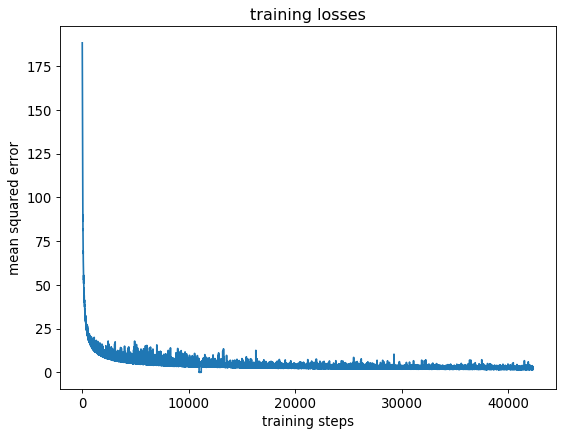

In [61]:
plt.plot(trn_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
plt.show()

In [18]:
device = torch.device("cpu")
# device = torch.device("cuda:0")

In [21]:
from chnet.models import UNet_loop as UNet
model = UNet(in_channels=1, out_channels=1, init_features=ngf, temporal=n_step).double().to(device)
model.load_state_dict(torch.load("out/unet_pytorch_ch32_1_500_loop.pt", map_location=device))
model.to(device)

UNet_loop(
  (unets): Sequential(
    (0): UNet(
      (encoder1): Sequential(
        (pad1): Padder()
        (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (enc1relu1): ReLU(inplace=True)
        (pad2): Padder()
        (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (enc1relu2): ReLU(inplace=True)
      )
      (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (encoder2): Sequential(
        (pad1): Padder()
        (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (enc2relu1): ReLU(inplace=True)
        (pad2): Padder()
        (enc2conv2): Conv2d(64, 64, kernel_size=(3,

In [24]:
%%time
x_val, y_val = ch_gen.data_generator(nsamples=4, 
                              dim_x=dim_x*10, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx=dx, 
                              dt=dt,
                              m_l=m_l, 
                              m_r=m_r,
                              n_step=n_step,
                              gamma=gamma, 
                              seed=389641,
                              device=torch.device("cuda:0"))


val_dataset = CahnHillDataset(x_val, y_val, transform_x=lambda x: x[:,None], transform_y=lambda x: x[:,None])
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=1)


total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)

No. of validation steps: 1
CPU times: user 15.6 s, sys: 6.55 s, total: 22.2 s
Wall time: 13.4 s


In [15]:
# prd_losses = []
# for item in val_loader:
#     torch.cuda.empty_cache()
#     model.eval()
#     x1 = item['x'].to(device)
#     y1 = item['y'].to(device)
#     # Forward pass
#     y2 = model(x1)
#     prd_losses.append(np.sqrt(criterion(y2, y1).item()))
# print(np.mean(prd_losses), np.std(prd_losses))

In [16]:
def mae_loss(x1, x2):
    return np.mean(np.fabs(x1-x2))

maerr = lambda x1, x2: np.fabs(x1-x2)
diff = lambda x1,x2: np.log(maerr(x1, x2))

t: 0, mae: 0.00143


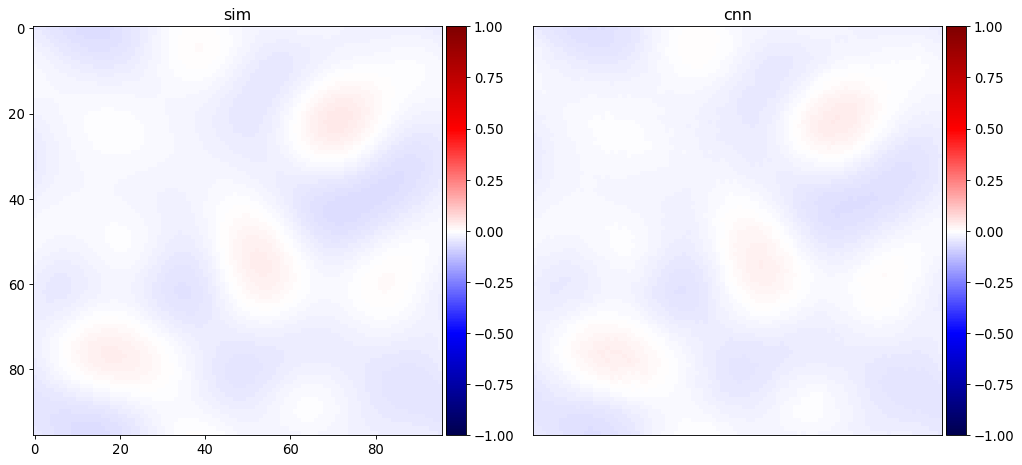

t: 1, mae: 0.00576


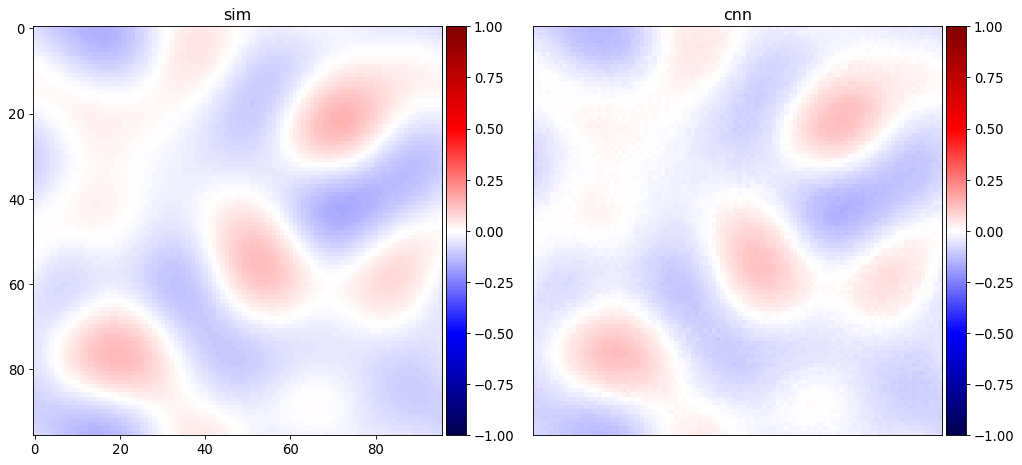

t: 2, mae: 0.02060


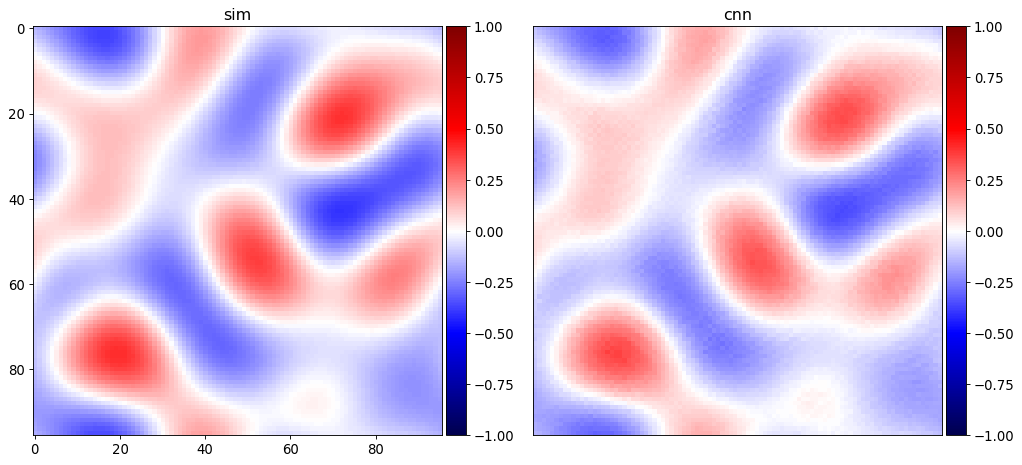

t: 3, mae: 0.03729


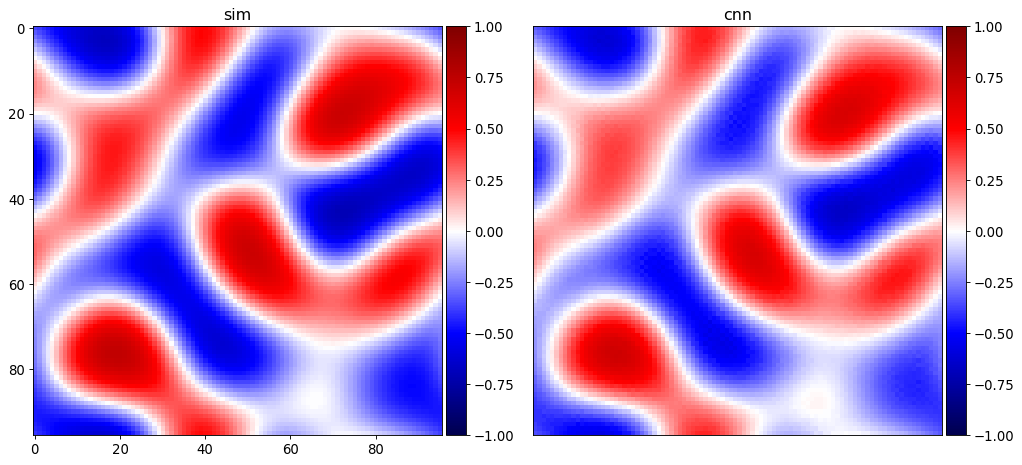

t: 4, mae: 0.03274


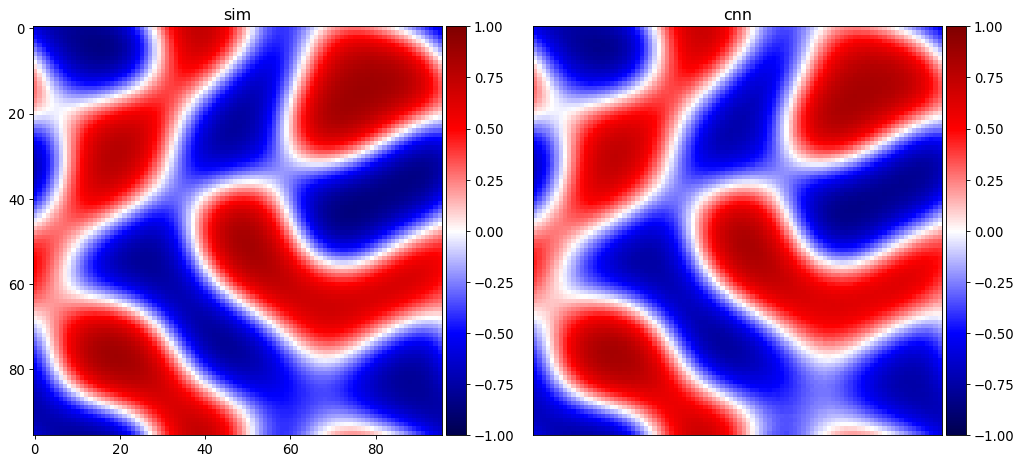

t: 5, mae: 0.02372


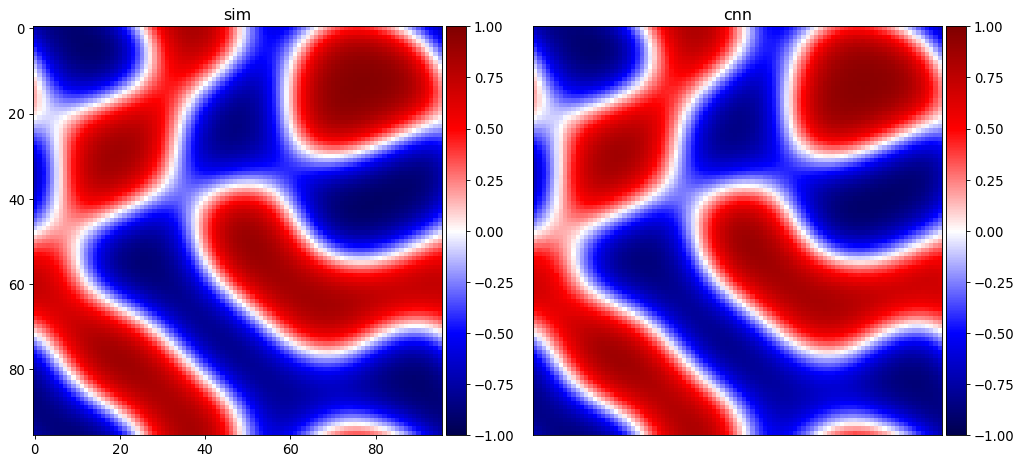

t: 6, mae: 0.02008


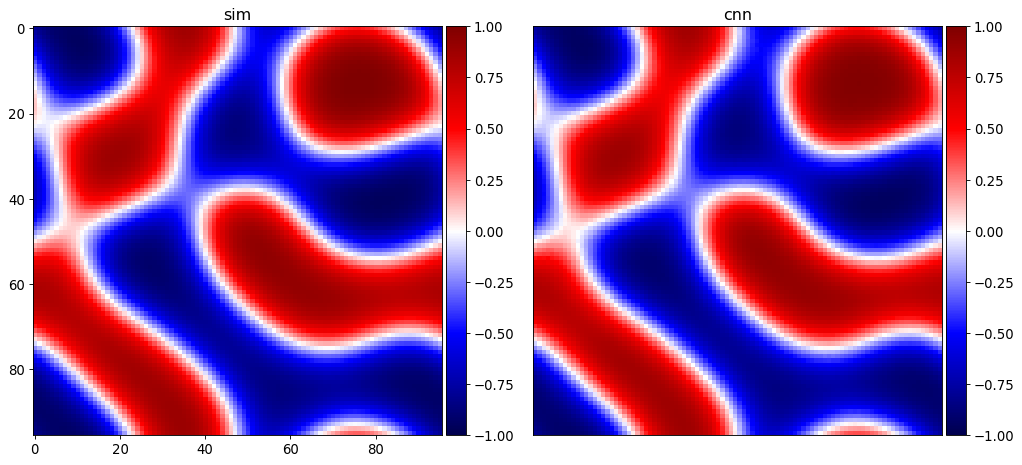

t: 7, mae: 0.01920


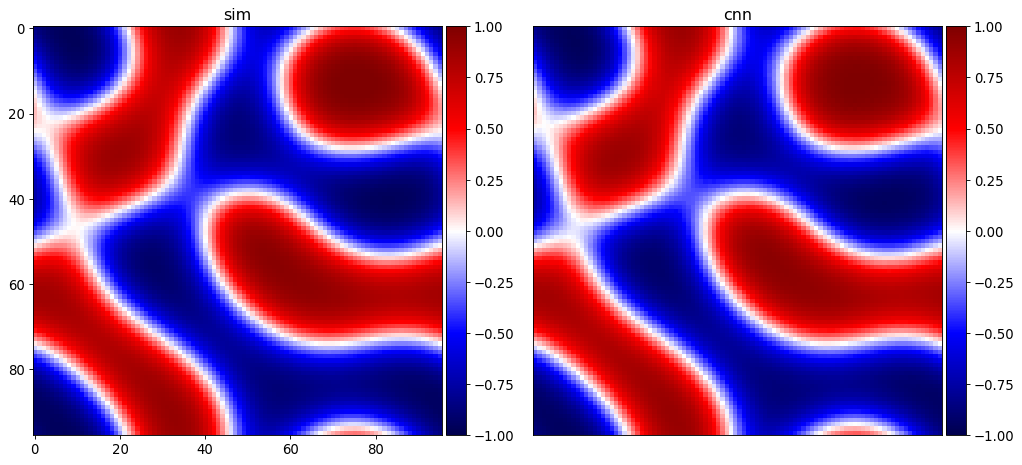

t: 8, mae: 0.01953


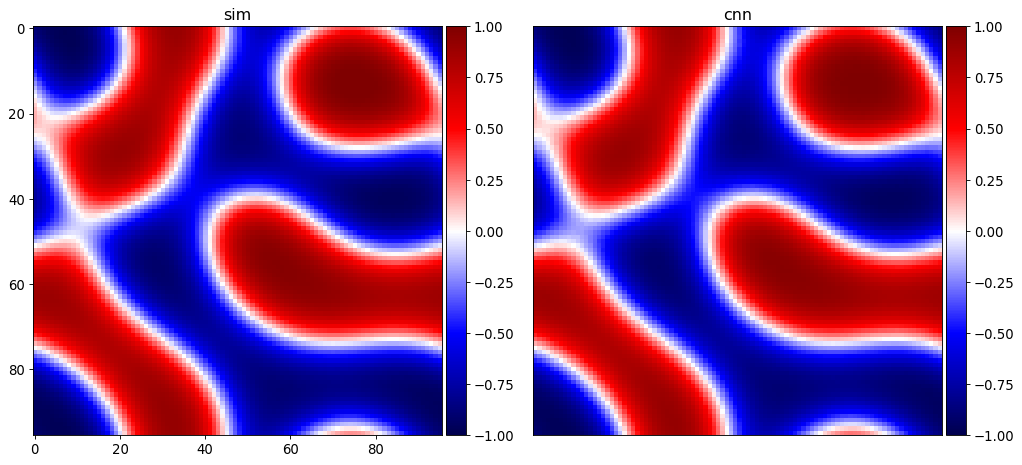

t: 9, mae: 0.02074


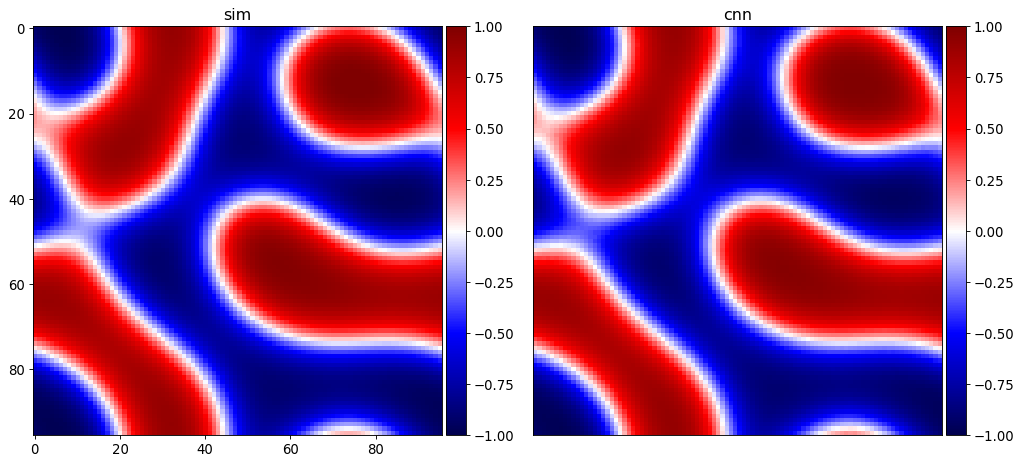

In [19]:
ix = 0

item_v = val_dataset[ix]
x1 = item_v['x'][None].to(device)
y1 = item_v['y'][None].to(device)

prd = x1[:,0]

torch.cuda.empty_cache()

model.eval()
model.to(device)
for t in range(n_step):

    prd = model.unets[t](prd)
#     im_x1 = x1[0,t,0].detach().cpu().numpy()
    im_y1 = y1[0,t,0].detach().cpu().numpy()
    im_y2 = prd[0, 0].detach().cpu().numpy()
    print("t: {}, mae: {:1.5f}".format(t, mae_loss(im_y1, im_y2)))
    ch_utils.draw_by_side([im_y1, im_y2], 
                          sub_titles=["sim", "cnn"], 
                          scale=8)

In [ ]:
errs = []
for ix in range(len(val_dataset)):

    item_v = val_dataset[ix]
    x1 = item_v['x'][None].to(device)
    y1 = item_v['y'][None].to(device)

    prd = x1[:,0]

    torch.cuda.empty_cache()

    model.eval()
    model.to(device)
    for t in range(n_step):

        prd = model.unets[t](prd)
        im_y1 = y1[0,t,0].detach().cpu().numpy()
        im_y2 = prd[0, 0].detach().cpu().numpy()
    
    errs.append(mae_loss(im_y1, im_y2))
    print("t: {}, mae: {:1.5f}".format(t, errs[-1]))
    ch_utils.draw_by_side([im_y1, im_y2], 
                          sub_titles=["sim", "cnn"], 
                          scale=8)

print("Mean err :{}, std: {}".format(np.mean(errs), np.std(errs)))